In [108]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
from itertools import combinations

In [61]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# import tidynamics as td

## Load and inspect the data

In [62]:
traj = md.load('data/water_nojump_3.xtc',top= 'data/water_top.pdb')
com = md.compute_center_of_mass(traj)
com.shape

(10000001, 3)

In [63]:
traj.timestep

0.1

In [64]:
df = pd.DataFrame(com, columns=['x', 'y', 'z'])
df['t'] = traj.time/1000

df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['x', 'y', 'z'], var_name='coord', )

df_melt.head()

,t,coord,value
0,0.0000,x,2.322035
1,0.0001,x,2.317498
2,0.0002,x,2.348874
3,0.0003,x,2.367788
4,0.0004,x,2.341420


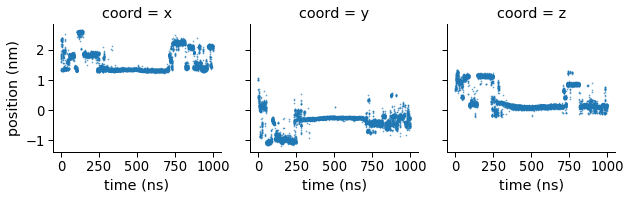

In [65]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(df_melt.iloc[::1000,:], col='coord')
    g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
    g.set_axis_labels('time (ns)', 'position (nm)')
    plt.savefig('thesis chapter/traj_3_xyz.png', bbox_inches='tight')

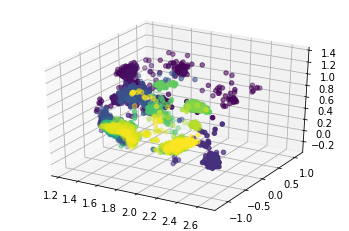

In [66]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])

### Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [67]:
dt_ps = traj.timestep
dt_ns = dt_ps/1000 # in ns
window = 1 # window size in ns
n_frames = int(window/dt_ns) # number of frames in a window
n_splits = com.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(com, n_splits) # the split up 

In [68]:
sample = pd.DataFrame(traj_split[136])
sample.head()

,0,1,2
0,2.578284,-0.985622,0.214775
1,2.611725,-1.000329,0.189633
2,2.612940,-0.944668,0.206004
3,2.637449,-0.994035,0.204889
4,2.605083,-0.988115,0.188019


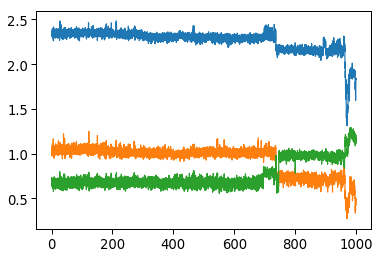

In [69]:
np.random.seed(42)
with sns.plotting_context('paper', font_scale=1.5):
    idx = 0
    stride = 1
    t = np.arange(traj_split[idx].shape[0])*dt_ps
    plt.plot(t[::stride], traj_split[idx][::stride, :])

In [72]:
dtrajs_obj = coor.cluster_kmeans(traj_split[idx], k = np.sqrt(n_frames).astype(int), max_iter=100)
dtrajs = dtrajs_obj.dtrajs

(0, 500)

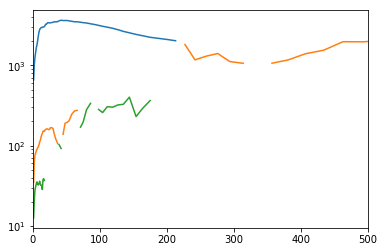

In [70]:
tica_lags = np.unique((np.logspace(np.log10(1), np.log10(600), 100)).astype(int))
ticas = [coor.tica(traj_split[idx], lag=int(lag/dt_ps), dim=3,  kinetic_map=True) for lag in tica_lags]
tica_eigs = np.concatenate([t.eigenvalues[:, np.newaxis] for t in ticas ], axis=1)
tica_ts = np.concatenate([t.timescales[:, np.newaxis] for t in ticas ], axis=1)
tica_ts = -tica_lags/dt_ps/np.log(tica_eigs)

plt.plot(tica_lags, tica_ts.T)
plt.yscale('log')
plt.xlim(0, 500)

In [122]:
vamps = [coor.vamp(traj_split[idx], lag=int(lag/float(dt_ps)), dim=3, scaling='km', right=True) for lag in tica_lags]
vamp_sv = np.concatenate([t.singular_values[:, np.newaxis] for t in vamps ], axis=1)
vamp_ts = -tica_lags/dt_ps/np.log(vamp_sv)


In [73]:
its = msm.its(dtrajs, lags=(tica_lags/dt_ps).astype(int), nits=5, errors='bayes')

In [178]:
vamp10 = vamps[1]
tica10 = ticas[1]
mm10 = msm.estimate_markov_model(dtrajs, lag=int(10/dt_ps))
mm100 = msm.estimate_markov_model(dtrajs, lag=int(100/dt_ps))
hmm10 = mm10.coarse_grain(2)
hmm100 = mm100.coarse_grain(2)
mms = [hmm10, vamp10]

In [179]:
titles = [r'HMM($\tau$=10ps)', r'VAMP($\tau$=10ps)']


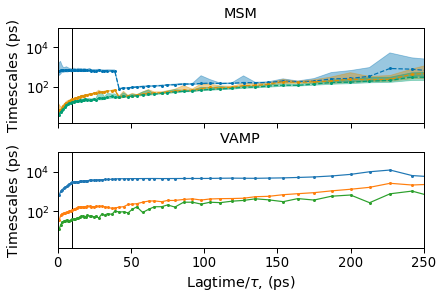

In [186]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
    xmax, ymax = 250, 10**5
    nits = 3
    colors = sns.color_palette('colorblind', nits)
    
    srt = np.argsort(its.lags)
    lags = its.lags
    for i in range(nits):
        axes[0].plot(
                lags[srt] * dt_ps, its.get_sample_mean(process=i)[srt] * dt_ps, marker='o',
                color=colors[i % len(colors)], linestyle='dashed', markersize=2)
        (lconf, rconf) = its.get_sample_conf(0.95, i)
        axes[0].fill_between(
            lags[srt]*dt_ps, lconf[srt]*dt_ps , rconf[srt]*dt_ps,
            alpha=0.4, color=colors[i % len(colors)])
    
    axes[0].set_yscale('log')
    axes[0].set_title('MSM', pad=10)
    axes[0].set_xlim(0, xmax)
    axes[0].set_ylim(0, ymax)
    
    
    axes[1].plot(tica_lags, vamp_ts.T, marker='o', ms=2)
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, xmax)
    axes[1].set_title('VAMP', pad=10)
    axes[1].set_xlabel(r'Lagtime/$\tau$, (ps)')
    

    
    for ax in axes:
        ax.vlines(10, 0, ymax, color='k', lw=1)
        ax.set_ylabel('Timescales (ps)')
    

    plt.tight_layout(h_pad=0.1, w_pad=0.1, pad=0.1)

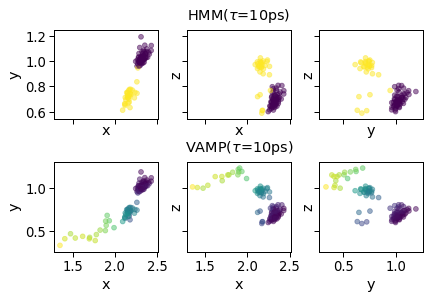

In [176]:

combs = list(combinations(range(3), 2))
ccs = dtrajs_obj.clustercenters
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(nrows=len(mms), ncols=len(combs), sharex='col', sharey='row')
    for i in range(len(mms)):
        if i < len(mms)/2:
            idxs = mms[i].observable_set
            cols = mms[i].metastable_assignments
        else:
            cols = mms[i].transform(ccs)[:, 0]
            idxs = np.arange(cols.shape[0])
        if cols[0] < 0: cols = cols*(-1)
        for j in range(len(combs)): 
            axes[i, j].scatter(x = ccs[idxs, combs[j][0]], y = ccs[idxs, combs[j][1]], 
                              c=cols, alpha=0.5)
            axis = ['x', 'y', 'z']

            axes[i, j].set_ylabel(axis[combs[j][1]])
            axes[i, j].set_xlabel(axis[combs[j][0]])
            if j == 1:
                axes[i, j].set_title(titles[i], pad=10)
    plt.tight_layout(h_pad=0.1, w_pad=0.1, pad=0.1)